In [38]:
cd("/Users/michael/work/GitHub/epinets")

In [39]:
include("EpiSim.jl")

Main.EpiSim

In [3]:
using CSV
using Plots
using LightGraphs

In [40]:
cd("/Users/michael/work/GitHub/COVID-19/csse_covid_19_data/csse_covid_19_time_series")

In [5]:
file="time_series_covid19_confirmed_global.csv"
allstates=["Australian Capital Territory" "New South Wales"  "Northern Territory" "Queensland" "South Australia" "Tasmania" "Victoria" "Western Australia"]

1×8 Array{String,2}:
 "Australian Capital Territory"  …  "Victoria"  "Western Australia"

In [6]:
z=[]
for state in allstates
    z=push!(z,EpiSim.getdata("Australia",state))
end

In [7]:
ddays=CSV.File(file)[1]
ddays=propertynames(ddays,4)[5:end]
ddays=String.(ddays)
ndays=length(ddays)

87

In [8]:
pops=[426709 8089526 245869 5095100 1751693 534281 6594804 2621680]

1×8 Array{Int64,2}:
 426709  8089526  245869  5095100  1751693  534281  6594804  2621680

In [25]:
#'reasonable' parameters
epiparam=Dict()
epiparam["p0"]=0.2 #a guess - tuned to match observed data 
epiparam["p2"]=1/12 #revised infection rate with distancing measure
epiparam["q"]=1/7 #"up to" two weeks
epiparam["r0"]=1/14 #about two weeks for mild, 3-6 for severe
epiparam["r2"]=1/4 #revised removal rate (now due to testing and isolation)
 #   ndays=120 #120 prediction (from patient(s) zere
 #   nsims=50 #50 runs
epiparam["nseeds"]=5 #probably too many, consider dropping.

5

In [10]:
i=1

1

In [33]:
epiparam["pop"]=pops[i]
epiparam["gridsize"]=Int(floor(sqrt(pop)))
y=z[i];

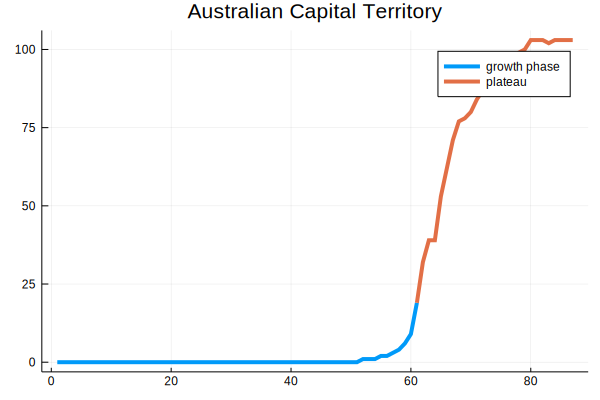

In [12]:
ddt(z,zt)=count(z->z>0, z[1:zt])+ count(z->z<0, z[zt+1:end])
~,tpday=findmax([ddt(diff(diff(y)),nx) for nx in 1:(ndays-2)])
#this is the turning point between exponential growth and decay. totItp total infections at day tpday
totItp=y[tpday+1]
plot(1:tpday+1,y[1:tpday+1],lw=4,label="growth phase",title=allstates[i])
plot!(tpday+1:ndays,y[tpday+1:ndays],lw=4,label="plateau")

In [45]:
bamodel=barabasi_albert(gridsize^2, 3, 2)
lattice=LightGraphs.grid((gridsize,gridsize),periodic=true)
wattstrog95=watts_strogatz(gridsize^2, 4, 0.013)  #s=0.013 => 95% compliance
wattstrog90=watts_strogatz(gridsize^2, 4, 0.026)  #s=0.026 => 90% compliance
wattstrog80=watts_strogatz(gridsize^2, 4, 0.053)  #s=0.053 => 80% compliance

{426409, 852818} undirected simple Int64 graph

In [46]:
St95,Et95,It95,Rt95=EpiSim.episim(bamodel,wattstrog95, epiparam, totItp, tpday+2, 90, 100)
St90,Et90,It90,Rt90=EpiSim.episim(bamodel,wattstrog90, epiparam, totItp, tpday+2, 90, 100)
St80,Et80,It80,Rt80=EpiSim.episim(bamodel,wattstrog80, epiparam, totItp, tpday+2, 90, 100)

100.0%┣████████████████████████████████████████┫ 100/100 [01:50<00:00, 0.9 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [01:48<00:00, 0.9 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [01:55<00:00, 0.9 it/s]


(UInt64[0x00000000000682d5 0x00000000000682d5 … 0x00000000000682d5 0x00000000000682d5; 0x00000000000682d5 0x00000000000682d5 … 0x00000000000682d5 0x00000000000682d5; … ; 0x0000000000066fbb 0x00000000000681e4 … 0x0000000000068244 0x00000000000681ff; 0x0000000000066fb8 0x00000000000681e4 … 0x0000000000068244 0x00000000000681ff], UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x0000000000000019 0x0000000000000002 … 0x0000000000000000 0x0000000000000005; 0x0000000000000019 0x0000000000000001 … 0x0000000000000000 0x0000000000000003], UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x000000000000000f 0x0000000000000001 … 0x0000000000000000 0x0000000000000001; 0x000000000000000d 0x0000000000000002 … 0x0000000000000000 0x0000000000000003], UInt64[0x000000

In [34]:
epiparam["pop"]

426709

In [47]:
plotly()

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /Users/michael/.julia/packages/Plots/cc8wh/src/backends.jl:363


Plots.PlotlyBackend()

In [49]:
plot(ddays,y,size=(1200,600),label=false)
EpiSim.plotquantiles(pop .- (Et90+St90),:blue,"90% Compliance")
EpiSim.plotquantiles(pop .- (Et95+St95),:green,"95% Compliance")
EpiSim.plotquantiles(pop .- (Et80+St80),:purple,"80% Compliance")
plot!(1:tpday+1,y[1:tpday+1],lw=4, color=:red,label="growth phase")
plot!(tpday+1:ndays,y[tpday+1:ndays],color=:yellow,lw=4,label="plateau",xlim=(0, 120), ylim=(0,2*y[end]))

<!DOCTYPE html>
 
 
 Plots.jl

In [ ]:
allrs=Dict()
rs=Array{Any,2}(undef,3,4)
for (i,statename) in enumerate(allstates)
    println("Working on ",statename)
    #get relevant data
    epiparam["pop"]=pops[i]
    epiparam["gridsize"]=Int(floor(sqrt(pop)))
    y=z[i];
    #compute turning point
    ddt(z,zt)=count(z->z>0, z[1:zt])+ count(z->z<0, z[zt+1:end])
    ~,tpday=findmax([ddt(diff(diff(y)),nx) for nx in 1:(ndays-2)])
    #this is the turning point between exponential growth and decay. totItp total infections at day tpday
    totItp=y[tpday+1]
    #build networks
    bamodel=barabasi_albert(gridsize^2, 3, 2)
    lattice=LightGraphs.grid((gridsize,gridsize),periodic=true)
    wattstrog95=watts_strogatz(gridsize^2, 4, 0.013)  #s=0.013 => 95% compliance
    wattstrog90=watts_strogatz(gridsize^2, 4, 0.026)  #s=0.026 => 90% compliance
    wattstrog80=watts_strogatz(gridsize^2, 4, 0.053)  #s=0.053 => 80% compliance
    #simulations
    St95,Et95,It95,Rt95=EpiSim.episim(bamodel,wattstrog95, epiparam, totItp, tpday+2, 90, 100)
    St90,Et90,It90,Rt90=EpiSim.episim(bamodel,wattstrog90, epiparam, totItp, tpday+2, 90, 100)
    St80,Et80,It80,Rt80=EpiSim.episim(bamodel,wattstrog80, epiparam, totItp, tpday+2, 90, 100)
    #store it all away
    rs[1,1]=St95
    rs[1,2]=Et95
    rs[1,3]=It95
    rs[1,4]=Rt95
    rs[2,1]=St90
    rs[2,2]=Et90
    rs[2,3]=It90
    rs[2,4]=Rt90
    rs[3,1]=St80
    rs[3,2]=Et80
    rs[3,3]=It80
    rs[3,4]=Rt80
    allrs[statename]=rs
end

Working on Australian Capital Territory
100.0%┣████████████████████████████████████████┫ 100/100 [01:50<00:00, 0.9 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [01:49<00:00, 0.9 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [02:00<00:00, 0.8 it/s]
Working on New South Wales
100.0%┣████████████████████████████████████████┫ 100/100 [17:57<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [17:33<00:00, 0.1 it/s]
54.0%┣██████████████████████▊                   ┫ 54/100 [09:55<08:37, 0.1 it/s]

In [59]:
    RS[1,1]=St95

152×100 Array{UInt64,2}:
 0x00000000000682d5  0x00000000000682d5  …  0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5  …  0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5  …  0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
 0x00000000000682d5  0x00000000000682d5     0x00000000000682d5
                  ⋮                      ⋱  
 0x0000000000068246  0x000000000006825a  …  0x000000000006810d
 0x0000000000068246  0x000000000006825a     0x00

In [58]:
RS=Array{Any,2}(undef,3,4)



3×4 Array{Any,2}:
 #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef